# News Analytics and Stock Price Performance: Model Tuning and Selection (part 3)
----

Can we use news analytics and market data to predict stock price performance? There is no doubt that the ubiquity of data today enables investors at any scale to make better investment decisions but to truly harness this power, we must be able to distinguish signal from noise.

This is a 3 part walkthrough of a Kaggle competition by Two Sigma, with the end result being a model that predicts a signed confidence of an assets fluctuation over a ten-day window.

$$\widehat{y}_{ti}\in[-1, 1]$$

Initially, I was a little confused with the evaluation process here.  Most people think of stock market predictions as being regression problems but this seemed like a binary classification problem to me.  An asset either has a positive or a negative return, with the signed confidence being used to indicate both the direction and the magnitude of this move.

as mentioned above, the signed confidence interval needs to be between [-1 and 1].  Binary classification models are going to output a probability, naturally being a number between 0 and 1.  So in order to get the output of my model to conform to this structure, I decided I would multiply my predicted value by 2 and then subtract 1.  If the predicted probability is 0, this will cause the output to be -1 and if the predicted probability is 1, then the output will be 1.


For each day in the evaluation time period, we calculate:
$$x_{t}=\sum_{i}\widehat{y}_{ti}r_{ti}u_{ti}$$
$$score=\frac{\bar{x}_{t}}{\sigma (x_{t})}$$

where $r_{ti}$ is the 10-day market-adjusted leading return for day $t$ for instrument $i$, and $u_{ti}$ is a 0/1 universe variable that controls whether a particular asset is included in scoring on a particular day.

Your submission score is then calculated as the mean divided by the standard deviation of your daily $x_{t}$ values:

If the standard deviation of predictions is 0, the score is defined as 0.

Two sources of data for this competition:

Market data (2007 to present) provided by Intrinio - contains financial market information such as opening price, closing price, trading volume, calculated returns, etc.

News data (2007 to present) Source: Thomson Reuters - contains information about news articles/alerts published about assets, such as article details, sentiment, and other commentary.

There are 3 notebooks for this walkthrough.  The first includes all of the EDA for both datasets.  In the second, I walk through feature preprocessing, exploration and engineering.  Finally, in the third notebook,  I build, test and tune multiple machine learning models.

In [1]:
import numpy as np
import pandas as pd
import os
from kaggle.competitions import twosigmanews
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
from sklearn.model_selection import train_test_split
from sklearn import ensemble
from sklearn.metrics import accuracy_score
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
import category_encoders as ce
from xgboost import plot_importance
import warnings
import gc
import psutil
warnings.filterwarnings('ignore')
%matplotlib inline

In [2]:
# Function to keep track of memory usage.  These DataFrames represent 10+ million rows and consume a lot of RAM
def cpuStats():
    pid = os.getpid()
    py = psutil.Process(pid)
    memoryUse = py.memory_info()[0] / 2. ** 30
    return 'memory GB:' + str(np.round(memoryUse, 2))

In [3]:
cpuStats()

'memory GB:0.26'

In [4]:
# Load training data from API
env = twosigmanews.make_env()
(market_train_df, news_train_df) = env.get_training_data()

Loading the data... This could take a minute.
Done!


In [5]:
cpuStats()

'memory GB:7.05'

In [6]:
print(f'market_train_df: {market_train_df.shape}')
market_train_df.head()

market_train_df: (4072956, 16)


,time,assetCode,assetName,volume,close,open,returnsClosePrevRaw1,returnsOpenPrevRaw1,returnsClosePrevMktres1,returnsOpenPrevMktres1,returnsClosePrevRaw10,returnsOpenPrevRaw10,returnsClosePrevMktres10,returnsOpenPrevMktres10,returnsOpenNextMktres10,universe
0,2007-02-01 22:00:00+00:00,A.N,Agilent Technologies Inc,2606900.0,32.19,32.17,0.005938,0.005312,NaN,NaN,-0.001860,0.000622,NaN,NaN,0.034672,1.0
1,2007-02-01 22:00:00+00:00,AAI.N,AirTran Holdings Inc,2051600.0,11.12,11.08,0.004517,-0.007168,NaN,NaN,-0.078708,-0.088066,NaN,NaN,0.027803,0.0
2,2007-02-01 22:00:00+00:00,AAP.N,Advance Auto Parts Inc,1164800.0,37.51,37.99,-0.011594,0.025648,NaN,NaN,0.014332,0.045405,NaN,NaN,0.024433,1.0
3,2007-02-01 22:00:00+00:00,AAPL.O,Apple Inc,23747329.0,84.74,86.23,-0.011548,0.016324,NaN,NaN,-0.048613,-0.037182,NaN,NaN,-0.007425,1.0
4,2007-02-01 22:00:00+00:00,ABB.N,ABB Ltd,1208600.0,18.02,18.01,0.011791,0.025043,NaN,NaN,0.012929,0.020397,NaN,NaN,-0.017994,1.0


In [7]:
print(f'news_train_df: {news_train_df.shape}')
news_train_df.head()

news_train_df: (9328750, 35)


,time,sourceTimestamp,firstCreated,sourceId,headline,urgency,takeSequence,provider,subjects,audiences,bodySize,companyCount,headlineTag,marketCommentary,sentenceCount,wordCount,assetCodes,assetName,firstMentionSentence,relevance,sentimentClass,sentimentNegative,sentimentNeutral,sentimentPositive,sentimentWordCount,noveltyCount12H,noveltyCount24H,noveltyCount3D,noveltyCount5D,noveltyCount7D,volumeCounts12H,volumeCounts24H,volumeCounts3D,volumeCounts5D,volumeCounts7D
0,2007-01-01 04:29:32+00:00,2007-01-01 04:29:32+00:00,2007-01-01 04:29:32+00:00,e58c6279551b85cf,China's Daqing pumps 43.41 mln tonnes of oil i...,3,1,RTRS,"{'ENR', 'ASIA', 'CN', 'NGS', 'EMRG', 'RTRS', '...","{'Z', 'O', 'OIL'}",1438,1,,False,11,275,"{'0857.HK', '0857.F', '0857.DE', 'PTR.N'}",PetroChina Co Ltd,6,0.235702,-1,0.500739,0.419327,0.079934,73,0,0,0,0,0,0,0,3,6,7
1,2007-01-01 07:03:35+00:00,2007-01-01 07:03:34+00:00,2007-01-01 07:03:34+00:00,5a31c4327427f63f,"FEATURE-In kidnapping, finesse works best",3,1,RTRS,"{'FEA', 'CA', 'LATAM', 'MX', 'INS', 'ASIA', 'I...","{'PGE', 'PCO', 'G', 'ESN', 'MD', 'PCU', 'DNP',...",4413,1,FEATURE,False,55,907,{'STA.N'},Travelers Companies Inc,8,0.447214,-1,0.600082,0.345853,0.054064,62,1,1,1,1,1,1,1,3,3,3
2,2007-01-01 11:29:56+00:00,2007-01-01 11:29:56+00:00,2007-01-01 11:29:56+00:00,1cefd27a40fabdfe,PRESS DIGEST - Wall Street Journal - Jan 1,3,1,RTRS,"{'RET', 'ENR', 'ID', 'BG', 'US', 'PRESS', 'IQ'...","{'T', 'DNP', 'PSC', 'U', 'D', 'M', 'RNP', 'PTD...",2108,2,PRESS DIGEST,False,15,388,"{'WMT.DE', 'WMT.N'}",Wal-Mart Stores Inc,14,0.377964,-1,0.450049,0.295671,0.254280,67,0,0,0,0,0,0,0,5,11,17
3,2007-01-01 12:08:37+00:00,2007-01-01 12:08:37+00:00,2007-01-01 12:08:37+00:00,23768af19dc69992,PRESS DIGEST - New York Times - Jan 1,3,1,RTRS,"{'FUND', 'FIN', 'CA', 'SFWR', 'INS', 'PUB', 'B...","{'T', 'DNP', 'PSC', 'U', 'D', 'M', 'RNP', 'PTD...",1776,6,PRESS DIGEST,False,14,325,"{'GOOG.O', 'GOOG.OQ', 'GOOGa.DE'}",Google Inc,13,0.149071,-1,0.752917,0.162715,0.084368,83,0,0,0,0,0,0,0,5,13,15
4,2007-01-01 12:08:37+00:00,2007-01-01 12:08:37+00:00,2007-01-01 12:08:37+00:00,23768af19dc69992,PRESS DIGEST - New York Times - Jan 1,3,1,RTRS,"{'FUND', 'FIN', 'CA', 'SFWR', 'INS', 'PUB', 'B...","{'T', 'DNP', 'PSC', 'U', 'D', 'M', 'RNP', 'PTD...",1776,6,PRESS DIGEST,False,14,325,{'XMSR.O'},XM Satellite Radio Holdings Inc,11,0.149071,-1,0.699274,0.209360,0.091366,102,0,0,0,0,0,0,0,0,0,0


A simple sanity check inspection of the data.

# Helper Functions
----

In [8]:
def label_cat(df, col):
    return df[col].astype('category').cat.as_ordered()

def bin_encode(df, cols_to_bin):
    ce_bin = ce.BinaryEncoder(cols = cols_to_bin)
    return ce_bin.fit_transform(df)

# Find all features with NaN's
def get_null_features(df):
    return df.columns[df.isna().any()].tolist()

# Returns either month, day or year of date -> expedites feature engineering 
def get_date_feature(df, col, date_type):
    if (date_type == 'year'):
        return pd.to_datetime(df[col]).dt.year
    elif (date_type == 'month'):
        return pd.to_datetime(df[col]).dt.month
    elif (date_type == 'quarter'):
        return pd.to_datetime(df[col]).dt.quarter
    else:
        return pd.to_datetime(df[col]).dt.dayofweek

# Helper function to print accuracy
def print_accuracy(model, x, y, x_val, y_val):
    print("Training Accuracy Score: ", accuracy_score(model.predict(x), y))
    print("Validation Accuracy Score: ", accuracy_score(model.predict(x_val), y_val))
    
# Helper function to get feature importances
def get_feature_imp(model, x):
    return pd.DataFrame(model.feature_importances_,
                                   index = x.columns,
                                    columns=['importance']).sort_values('importance', ascending=False)

# Calculate the RSI
def RSI(series, period):
    delta = series.diff().dropna()
    u = delta * 0
    d = u.copy()
    u[delta > 0] = delta[delta > 0]
    d[delta < 0] = -delta[delta < 0]
    u[u.index[period-1]] = np.mean( u[:period] ) #first value is sum of avg gains
    u = u.drop(u.index[:(period-1)])
    d[d.index[period-1]] = np.mean( d[:period] ) #first value is sum of avg losses
    d = d.drop(d.index[:(period-1)])
    rs = u.ewm(com=period-1, adjust=False).mean() / d.ewm(com=period-1, adjust=False).mean()
    return 100 - 100 / (1 + rs)

# 80%, 20%
def temploral_split(df, labels):
    X_train, X_val = np.split(df, [int(.8*len(df))])
    y_t, y_v = np.split(labels, [int(.8*len(labels))])
    
    y_train = y_t > 0    
    y_val = y_v > 0
    
    return [X_train, y_train, X_val, y_val]

# Join 2 dataframes
def join_df(left, right, left_on, right_on=None, suffix='_y'):
    if right_on is None: right_on = left_on
    return left.merge(right, how='left', left_on=left_on, right_on=right_on, 
                      suffixes=("", suffix))

## Preparing the Data

Here I have compiled all of the data preprocessing steps into a few functions.  I had to remove a few processes here.  Imputing and normalizing the data caused issues with the test set provided by Kaggle.  The test set is pulled in via a provided python generator and the results I was getting on the provided test set were bizarre after normalizing.  I also removed the tf-idf feature that I experimented with in part 2.  It didn't seem to add much to the model performance and it greatly increased my data preprocessing time.  it was causing my test set process at the bottom of this notebook to take around 30 minutes.

In [9]:
# Prep market data
def prep_market(df):
    # We will be using the assetCode
    df.drop(['assetName'], axis=1, inplace=True)
    _ = gc.collect()
    
    df['time'] = df.time.dt.strftime("%Y%m%d").astype(int)
    
    # Create year, month, day features
    df['month'] = get_date_feature(df, 'time', 'month')
    df['day'] = get_date_feature(df, 'time', 'day')
    df['quarter'] = get_date_feature(df, 'time', 'quarter')
    
    # Some feature engineering -> moving averages
    for n in [14, 30, 50, 200]:
        # Create the moving averages
        df['close_ma' + str(n)] = df['close'].rolling(window=n).mean()
    
    # Create RSI -> only 14 was useful during feature exploration
    df['rsi14'] = RSI(df['close'], 14)
    
    # 10 day pct change in volume
    df['vol_pct_change'] = df['volume'].pct_change()
    df['vol_pct_10'] = df['vol_pct_change'].rolling(window=10).mean()
        
    # drop 200 rows -> this is because of the moving average calculations
    df.dropna(inplace=True)
    _ = gc.collect()
    
    # These were identified in part 2 -> returnsOpenNextMktres10 is the dependant var
    train_cols = ['returnsClosePrevRaw10',
                  'returnsClosePrevMktres10',  
                  'close',
                  'rsi14', 
                  'assetCode',
                  'month', 
                  'close_ma14',
                  'close_ma200',
                  'close_ma30',
                  'volume',
                  'close_ma50',
                  'returnsClosePrevMktres1', 
                  'returnsClosePrevRaw1',
                  'returnsOpenPrevRaw1',
                  'vol_pct_10',
                  'day',
                  'quarter',
                  'time']
    
    # This is for the final trainin set contidion
    if 'returnsOpenNextMktres10' in df.columns:
        train_cols = train_cols + ['returnsOpenNextMktres10']
    
    df = df[train_cols]
    
    return df

In [10]:
# Prep news data
def prep_news(df):
    
    drop_list = [
        'audiences', 'subjects', 'assetName',
        'firstCreated', 'sourceTimestamp',
    ]
    df.drop(drop_list, axis=1, inplace=True)
    _ = gc.collect()
    
    # convert the date
    df['time'] = df.time.dt.strftime("%Y%m%d").astype(int)
    
    # convert the assets codes to a usable format
    df['assetCode'] = df['assetCodes'].map(lambda x: list(eval(x))[0])
    
    # encode provider
    df['provider'] = label_cat(df, 'provider').cat.codes

    # determine the proportion of the news item discussing the asset
    df['coverage'] = df['sentimentWordCount'] / df['wordCount']

    # relative position of the first mention in the item
    df['position'] = df['firstMentionSentence'] / df['sentenceCount']
    
    # Drop some unnecessary news features 
    droplist = ['takeSequence','headlineTag',
                'assetCodes', 'headline', 'marketCommentary']

    df.drop(droplist, axis=1, inplace=True)
    _ = gc.collect()
    
    # combine multiple news reports for same assets on same day
    newsgp = df.groupby(['time','assetCode'], sort=False).aggregate(np.mean).reset_index()
    
    return newsgp

In [11]:
# Function for all data processing
def prep_data(market_train_df, news_train_df):
    market_train = prep_market(market_train_df)
    news_train = prep_news(news_train_df)
    
    joined = join_df(market_train, news_train, ['time', 'assetCode'], ['time', 'assetCode'])

    # many assets that will have many days without news data
    joined[news_train.columns[2:].values] = joined[news_train.columns[2:].values].fillna(value=0)
    joined.drop(['time'], axis=1, inplace=True)
    # joined['assetCode'] = label_cat(joined, 'assetCode').cat.codes
    
    del market_train
    del news_train
    _ = gc.collect()
    
    return joined

In [12]:
ts_df = prep_data(market_train_df, news_train_df)

In [13]:
print(f'Shape: {ts_df.shape}')
ts_df.head()

Shape: (3978176, 43)


,returnsClosePrevRaw10,returnsClosePrevMktres10,close,rsi14,assetCode,month,close_ma14,close_ma200,close_ma30,volume,close_ma50,returnsClosePrevMktres1,returnsClosePrevRaw1,returnsOpenPrevRaw1,vol_pct_10,day,quarter,returnsOpenNextMktres10,urgency,provider,bodySize,companyCount,sentenceCount,wordCount,firstMentionSentence,relevance,sentimentClass,sentimentNegative,sentimentNeutral,sentimentPositive,sentimentWordCount,noveltyCount12H,noveltyCount24H,noveltyCount3D,noveltyCount5D,noveltyCount7D,volumeCounts12H,volumeCounts24H,volumeCounts3D,volumeCounts5D,volumeCounts7D,coverage,position
0,0.050947,0.039098,33.83,49.188498,A.N,1,41.899857,39.80799,42.904933,4095135.0,41.09636,0.026171,0.027019,0.004262,1.444249,3,1,-0.029993,1.769231,24.307692,3075.846154,1.000000,19.153846,464.384615,1.000000,1.000000,-0.153846,0.183994,0.564769,0.251237,274.692308,2.153846,2.153846,2.153846,2.153846,2.153846,8.153846,8.153846,10.153846,18.153846,19.153846,0.952583,0.644801
1,0.049460,0.006601,11.67,46.480354,AAI.N,1,37.333429,39.69464,42.268600,1378650.0,39.48856,-0.003326,-0.002564,0.003445,1.257167,3,1,-0.013111,2.400000,24.800000,2355.100000,1.800000,14.000000,406.900000,0.700000,0.906066,0.300000,0.129506,0.597227,0.273268,346.000000,0.800000,0.800000,0.800000,0.800000,0.800000,5.400000,6.100000,8.000000,8.400000,8.400000,0.921061,0.238395
2,0.033058,0.033965,38.75,50.096165,AAP.N,1,36.466286,39.70244,42.791933,3884400.0,39.90516,0.046114,0.046731,-0.015957,1.527694,3,1,-0.028244,1.666667,24.777778,2150.611111,1.111111,10.944444,321.722222,1.000000,1.000000,-0.166667,0.173526,0.570563,0.255912,154.277778,3.222222,3.222222,3.222222,3.222222,3.277778,11.111111,12.000000,13.055556,13.111111,14.111111,0.848543,0.697263
3,0.005546,-0.020233,85.21,55.634205,AAPL.O,1,40.362714,39.96674,44.351933,12997017.0,41.07316,-0.002337,-0.001055,0.008035,1.717506,3,1,-0.014505,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,0.025527,0.009882,18.48,47.483559,ABB.N,1,37.394857,39.64679,43.314267,10168100.0,40.55996,-0.035524,-0.033978,-0.022240,1.708858,3,1,0.017172,2.230769,26.000000,983.923077,1.538462,8.076923,188.461538,1.769231,0.919368,0.615385,0.091920,0.332099,0.575981,117.846154,0.923077,0.923077,0.923077,0.923077,1.000000,7.692308,7.692308,11.692308,12.692308,13.692308,0.840292,0.488877


In [14]:
# Save memory
del market_train_df
del news_train_df
_ = gc.collect()

## Training

As I have said before, since we are dealing with large DataFrames, I am going to start training my models on a small sample of the data. I think it’s important to be able to iterate quickly in the early phases and this will enable me to experiment quickly. I'll start by taking the last (most recent) 200,000 records with an 80/20 split.

I could have used GridSearchCV here to find the optimal parameters for my Random forest and GB models.  Using GridSearchCV in its conventional way doesn't make sense here because we are dealing with temporal data.  Cross-validation would destroy the temporal nature.  What I could have done though is manually created my splits in sequence and then passed an array of tuples containing the IDX of these splits for the training data and test data to the cv parameter.  I didn't realize GridSearchCV could be used this way.  Documentation to the rescue!

The issue here is that I am facing serious memory limitations due to the size of the data.  GridSearchCV causes my kernel to crash.

In [15]:
# These cols are needed for the final prediction process
train_cols = [col for col in ts_df.columns if col not in ['assetCode', 'universe', 'returnsOpenNextMktres10']]

In [16]:
X_train_sample, y_train_sample, X_val_sample, y_val_sample = temploral_split(ts_df.iloc[-200000:][train_cols], ts_df.iloc[-200000:]['returnsOpenNextMktres10'])

In [17]:
print(f'X_train_sample: {X_train_sample.shape}')
print(f'X_val_sample: {X_val_sample.shape}')

X_train_sample: (160000, 41)
X_val_sample: (40000, 41)


In [18]:
rfc = ensemble.RandomForestClassifier(n_estimators=30, min_samples_leaf=100, max_features=0.5, n_jobs=-1, random_state=23)
%time rfc.fit(X_train_sample, y_train_sample)

CPU times: user 1min 13s, sys: 68 ms, total: 1min 13s
Wall time: 19.3 s


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features=0.5, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=100, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=30, n_jobs=-1,
            oob_score=False, random_state=23, verbose=0, warm_start=False)

In [19]:
print_accuracy(rfc, X_train_sample, y_train_sample, X_val_sample, y_val_sample)

Training Accuracy Score:  0.6802375
Validation Accuracy Score:  0.5264


Seems to be overfitting a little.  In my previous notebook, my RF models were hoving around 52% as well.  Let's try XGBoost and see if my results differ.

In [20]:
feature_importances = get_feature_imp(rfc, X_train_sample)
feature_importances[0:30]

,importance
returnsClosePrevMktres10,0.102820
rsi14,0.094781
close,0.091995
returnsClosePrevRaw10,0.089862
close_ma200,0.086754
close_ma14,0.085450
close_ma50,0.077206
close_ma30,0.075708
volume,0.065846
returnsClosePrevMktres1,0.051599


Interesting to see 4 of the features I created are near the top of the feature importance list.

## XGBoost

In [21]:
xgb = XGBClassifier(objective='binary:logistic', n_estimators=50, colsample_bytree=0.3, learning_rate=0.1, max_depth=3, n_jobs=4, seed=23)
%time  xgb.fit(X_train_sample, y_train_sample)

CPU times: user 10.7 s, sys: 16 ms, total: 10.7 s
Wall time: 2.8 s


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.3, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=50,
       n_jobs=4, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=23, silent=True,
       subsample=1)

In [22]:
print_accuracy(xgb, X_train_sample, y_train_sample, X_val_sample, y_val_sample)

Training Accuracy Score:  0.55454375
Validation Accuracy Score:  0.528225


Slightly better than the RF model and not overfitting as severely (max_depth is 3).  Let's try tweaking the parameters a little.

In [23]:
xgb_2 = XGBClassifier(objective='binary:logistic', n_estimators=200, colsample_bytree=0.8, learning_rate=0.01, max_depth=6, n_jobs=4, seed=23)
%time  xgb_2.fit(X_train_sample, y_train_sample)

CPU times: user 2min 42s, sys: 168 ms, total: 2min 42s
Wall time: 41.1 s


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.8, gamma=0, learning_rate=0.01, max_delta_step=0,
       max_depth=6, min_child_weight=1, missing=None, n_estimators=200,
       n_jobs=4, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=23, silent=True,
       subsample=1)

In [24]:
print_accuracy(xgb_2, X_train_sample, y_train_sample, X_val_sample, y_val_sample)

Training Accuracy Score:  0.58020625
Validation Accuracy Score:  0.525


Not really much of a change.

Instead of using all features, let's try using the top 20 from our RF feature importances.

In [25]:
# feature_importances[0:20]
xgb_4 = XGBClassifier(objective='binary:logistic', n_estimators=100, colsample_bytree=0.5, learning_rate=0.01, max_depth=5, n_jobs=4, seed=23)
%time  xgb_4.fit(X_train_sample[list(feature_importances[0:20].index)], y_train_sample)

CPU times: user 35.1 s, sys: 60 ms, total: 35.1 s
Wall time: 8.89 s


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_delta_step=0,
       max_depth=5, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=4, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=23, silent=True,
       subsample=1)

In [26]:
print_accuracy(xgb_4, X_train_sample[list(feature_importances[0:20].index)], y_train_sample, X_val_sample[list(feature_importances[0:20].index)], y_val_sample)

Training Accuracy Score:  0.56085625
Validation Accuracy Score:  0.518325


Not really any change.  These features might not be very important to the model.

# LGBM

In [27]:
lgb = LGBMClassifier(n_estimators=200, learning_rate=0.01, max_depth=10, colsample_bytree=0.8, n_jobs=4)
%time lgb.fit(X_train_sample, y_train_sample)

CPU times: user 17.3 s, sys: 236 ms, total: 17.6 s
Wall time: 4.76 s


LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=0.8,
        importance_type='split', learning_rate=0.01, max_depth=10,
        min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
        n_estimators=200, n_jobs=4, num_leaves=31, objective=None,
        random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
        subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [28]:
print_accuracy(lgb, X_train_sample, y_train_sample, X_val_sample, y_val_sample)

Training Accuracy Score:  0.5727
Validation Accuracy Score:  0.52505


The LGBM model trains much faster than XGBoost and we get the same results.

## Random Search

Time for some parameter tuning.

In [29]:
# Let's bump it up to 500,000 records to experiment with
X_train_sample, y_train_sample, X_val_sample, y_val_sample = temploral_split(ts_df.iloc[-500000:][train_cols], ts_df.iloc[-500000:]['returnsOpenNextMktres10'])
_ = gc.collect()

In [30]:
param_grid = {
    'learning_rate': [0.15, 0.1, 0.05, 0.02, 0.01],
    'num_leaves': [i for i in range(12, 90, 6)],
    'n_estimators': [50, 200, 400, 600, 800],
    'min_child_samples': [i for i in range(10, 100, 10)],
    'colsample_bytree': [0.8, 0.9, 0.95, 1],
    'subsample': [0.8, 0.9, 0.95, 1],
    'reg_alpha': [0.1, 0.2, 0.4, 0.6, 0.8],
    'reg_lambda': [0.1, 0.2, 0.4, 0.6, 0.8],
}

best_acc = 0
for i in range(10):
    params = {k: np.random.choice(v) for k, v in param_grid.items()}

    model = LGBMClassifier(**params)
    model.fit(X_train_sample, y_train_sample)
    acc = accuracy_score(model.predict(X_val_sample), y_val_sample)
    
    if acc > best_acc or best_acc == 0:
        best_acc = acc
        best_params = params
print(f'Best Score: {best_acc}')
print(f'Best Paramas: {best_params}')

Best Score: 0.53711
Best Paramas: {'learning_rate': 0.05, 'num_leaves': 48, 'n_estimators': 50, 'min_child_samples': 10, 'colsample_bytree': 0.9, 'subsample': 0.95, 'reg_alpha': 0.8, 'reg_lambda': 0.2}


In [31]:
lgb = LGBMClassifier(**best_params, n_jobs=4)
%time lgb.fit(X_train_sample, y_train_sample)

CPU times: user 13.4 s, sys: 460 ms, total: 13.8 s
Wall time: 4.13 s


LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=0.9,
        importance_type='split', learning_rate=0.05, max_depth=-1,
        min_child_samples=10, min_child_weight=0.001, min_split_gain=0.0,
        n_estimators=50, n_jobs=4, num_leaves=48, objective=None,
        random_state=None, reg_alpha=0.8, reg_lambda=0.2, silent=True,
        subsample=0.95, subsample_for_bin=200000, subsample_freq=0)

In [32]:
print_accuracy(lgb, X_train_sample, y_train_sample, X_val_sample, y_val_sample)

Training Accuracy Score:  0.56181
Validation Accuracy Score:  0.53711


In [33]:
del X_train_sample
del y_train_sample
del X_val_sample
del y_val_sample
_ = gc.collect()

## Final

Time to train a model on the entire dataset.

In [34]:
X_train, y_train, X_val, y_val = temploral_split(ts_df[train_cols], ts_df['returnsOpenNextMktres10'])

del ts_df
_ = gc.collect()

In [35]:
lgb_final = LGBMClassifier(**best_params, n_jobs=4)
%time  lgb_final.fit(X_train, y_train)

CPU times: user 2min 4s, sys: 3.66 s, total: 2min 8s
Wall time: 36.5 s


LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=0.9,
        importance_type='split', learning_rate=0.05, max_depth=-1,
        min_child_samples=10, min_child_weight=0.001, min_split_gain=0.0,
        n_estimators=50, n_jobs=4, num_leaves=48, objective=None,
        random_state=None, reg_alpha=0.8, reg_lambda=0.2, silent=True,
        subsample=0.95, subsample_for_bin=200000, subsample_freq=0)

In [36]:
print("Validation Accuracy Score: ", accuracy_score(lgb_final.predict(X_val), y_val))

Validation Accuracy Score:  0.5411042235394075


## Feature Importances

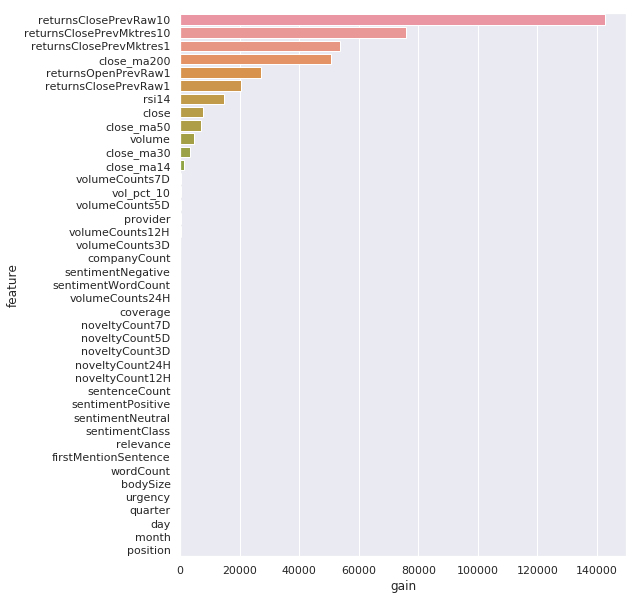

In [37]:
feat_importance = pd.DataFrame()
feat_importance["feature"] = X_train.columns
feat_importance["gain"] = lgb_final.booster_.feature_importance(importance_type='gain')
feat_importance.sort_values(by='gain', ascending=False, inplace=True)
plt.figure(figsize=(8,10))
ax = sns.barplot(y="feature", x="gain", data=feat_importance)

In [ ]:
del X_train
del y_train
del X_val
del y_val
_ = gc.collect()

# Test set

In [ ]:
def write_submission(model, env):
    days = env.get_prediction_days()
    for (market_df, news_df, predictions_template_df) in days:

        pd_df = prep_data(market_df, news_df)
        
        pd_df = pd_df[pd_df.assetCode.isin(predictions_template_df.assetCode)]
        
        # Drop cols that are not features
        feats = [c for c in pd_df.columns if c not in ['assetCode', 'universe']]
        
        # (* 2 - 1) used to cap predictions into required confidence intervals
        preds = lgb_final.predict_proba(pd_df[feats])[:, 1] * 2 - 1
        sub = pd.DataFrame({'assetCode': pd_df['assetCode'], 'confidence': preds})
        predictions_template_df = predictions_template_df.merge(sub, how='left').drop(
            'confidenceValue', axis=1).fillna(0).rename(columns={'confidence':'confidenceValue'})
        
        env.predict(predictions_template_df)
    env.write_submission_file()
    
write_submission(lgb_final, env)